# Install and Import Library

In [ ]:
!pip install tweet-preprocessor
!pip install modelzoo-client[transformers]
!pip install -q keras-rectified-adam

!git lfs install
!git clone https://huggingface.co/indolem/indobert-base-uncased

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 KB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.8/82.8 KB 11.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 789.1/789.1 KB 43.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 89.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 94.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 22.8 MB/s eta 0:00:00
  Created wheel for names: filename=names-0.3.0-py3-none-any.whl size=803699 sha256=f7362ea0ecfec7414fc05f084f0fc59db138febe87f9fef276dd504222fa416c
  Stored in directory: /root/.cache/pip/wheels/d0/35/f7/c72132a4f3878b82018a3e61bf2a35e6b6

In [ ]:
import pandas as pd
import re
import numpy as np
import preprocessor as p
import tensorflow as tf
import matplotlib.pyplot as plt
from google.colab import drive
from transformers import BertTokenizer, TFBertModel
from keras_radam import RAdam
from keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn.metrics import ConfusionMatrixDisplay,precision_score,recall_score,f1_score, classification_report

# Preparation

In [ ]:
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
dataset_path = "/content/drive/My Drive/thesisHilman/dataset/"
dataset = pd.read_csv(dataset_path+"dataset-1.csv")

In [ ]:
dataset.head(5)

,sentiment,aspek,Tweet
0,0,0,absen sekali langsung sakit semua wkwkw
1,0,0,aduuuh sakit sekali perutku
2,0,0,agak drama selama berangkat pulang perut kumat...
3,0,0,agak sakit tapi tidak apa apa karena walau sak...
4,0,0,aish tidak bisa tidur seharian ini sudah banya...


In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(dataset['Tweet'],dataset[['sentiment','aspek']],test_size = 0.2, random_state = 42)

In [ ]:
X_train = x_train.values

Y_train = (pd.get_dummies(y_train.aspek.values)).values

X_val = x_test.values

Y_val = (pd.get_dummies(y_test.aspek.values)).values

X_test = x_test.values

Y_test = (pd.get_dummies(y_test.aspek.values)).values

In [ ]:
tokenizer = BertTokenizer.from_pretrained("indobert-base-uncased")
indobert_model = TFBertModel.from_pretrained("indobert-base-uncased", from_pt=True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predict

In [ ]:
slang_txt = open(dataset_path+'slangword.txt',"r",encoding="utf-8", errors='replace')
slang = slang_txt.readlines(); slang_txt.close()
slang = [t.strip('\n').strip() for t in slang]
slang = [t.split(":") for t in slang]
slang = [[k.strip(), v.strip()] for k,v in slang]
slang = {k:v for k,v in slang}

# Hyperparameter

In [ ]:
max_seq = 128
lr = 2e-5   # or 5e-5
epochs = 2
batch_size = 16   # or 32
dropout_prob = 0.2

# Text Preprocessing

In [ ]:
def text_preprocess(sentence):
  sentence = sentence.encode().decode('unicode_escape') #remove escape
  sentence = sentence.lower() #case folding
  sentence = sentence.lstrip('b') #remove first char (b)
  sentence = re.sub(r'\n', ' ', sentence) #remove enter
  sentence = p.clean(sentence) #remove username,hashtag,url,emoji
  sentence = re.sub(r'[^\w\s]', ' ', sentence) #remove punctuation
  sentence = re.sub(r'[0-9]', ' ', sentence) #remove number
  sentence = sentence.split()
  for i in range(len(sentence)):
    #remove adjacent duplicate characters
    if re.sub(r'([a-z])\1+', r'\1\1', sentence[i]) in tokenizer.vocab.keys():
      sentence[i] = re.sub(r'([a-z])\1+', r'\1\1', sentence[i])
    else:
      if re.sub(r'([a-z])\1+', r'\1', sentence[i]) in tokenizer.vocab.keys():
        sentence[i] = re.sub(r'([a-z])\1+', r'\1', sentence[i])
      else:
        sentence[i] = re.sub(r'([a-z])\1+', r'\1\1', sentence[i])
    #replace slang and abbreviations into standard language
    if sentence[i] in slang.keys():
      sentence[i] = slang[sentence[i]]
  sentence = ' '.join(sentence)
  return sentence

In [ ]:
def delete_leaked_word(sentence):
  erased_word = ['kesehatan', 'pendidikan', 'pekerjaan', 'pendapatan', 'keamanan', 
                 'hubungan sosial', 'ketersediaan waktu luang','keharmonisan keluarga','lingkungan hidup']
  sentence = sentence.split()
  output = []
  for i in range(len(sentence)):
    if sentence[i] not in erased_word:
      output.append(sentence[i])
  output = ' '.join(output)
  return output

In [ ]:
def batch_encode(X, tokenizer):
  return tokenizer.batch_encode_plus(X,
                                     max_length=max_seq, # set the length of the sequences
                                     add_special_tokens=True, # add [CLS] and [SEP] tokens
                                     return_attention_mask=True,
                                     return_token_type_ids=False, # not needed for this type of ML task
                                     padding='max_length', # add 0 pad tokens to the sequences less than max_length
                                     return_tensors='tf')

In [ ]:
def preprocess_data(data):
  for i in range(len(data)):
    data[i] = text_preprocess(data[i])
    # data[i] = delete_leaked_word(data[i])
  data = batch_encode(data, tokenizer)
  return data.values()

In [ ]:
X_train = preprocess_data(X_train)
X_val = preprocess_data(X_val)
X_test = preprocess_data(X_test)


## Text Preprocessing Sample

In [ ]:
PRE_TRAINED_MODEL_NAME = 'indobert-base-uncased'

In [ ]:
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
sample_txt = 'badan sakit semua karena habis pelukan sama aspal'

In [ ]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: badan sakit semua karena habis pelukan sama aspal
   Tokens: ['badan', 'sakit', 'semua', 'karena', 'habis', 'pelukan', 'sama', 'aspal']
Token IDs: [2835, 2764, 2014, 1686, 5594, 23544, 1959, 21655]


### Special Tokens

`[SEP]` - marker for ending of a sentence


In [ ]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 4)

In [ ]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 3)

In [ ]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

In [ ]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 1)

In [ ]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=64,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  #padding=max_length,
  #truncation=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)
encoding.keys()


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


dict_keys(['input_ids', 'attention_mask'])

In [ ]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

64


tensor([    3,  2835,  2764,  2014,  1686,  5594, 23544,  1959, 21655,     4,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])

In [ ]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

64


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'badan',
 'sakit',
 'semua',
 'karena',
 'habis',
 'pelukan',
 'sama',
 'aspal',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

# Model Architecture

In [ ]:
input_word_ids = tf.keras.layers.Input(shape=(max_seq,), name='input_word_ids', dtype='int32')
input_mask_ids = tf.keras.layers.Input(shape=(max_seq,), name='input_mask_ids', dtype='int32')
indobert = indobert_model([input_word_ids, input_mask_ids])
sequence_output = indobert['last_hidden_state']
dropout = tf.keras.layers.Dropout(dropout_prob)(sequence_output)
lstm = tf.keras.layers.LSTM(768, return_sequences=True)(dropout)
pooling = tf.keras.layers.GlobalAveragePooling1D()(lstm)    # or GlobalMaxPooling1D()
hidden = tf.keras.layers.Dense(768, activation='relu')(pooling)
outputs = tf.keras.layers.Dense(9, activation='softmax')(hidden)
model = tf.keras.models.Model(inputs = [input_word_ids,input_mask_ids], outputs = outputs)

model.compile(
  optimizer=RAdam(learning_rate=lr),
  loss='categorical_crossentropy', 
  metrics=['accuracy']
)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 input_mask_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  110558208   ['input_word_ids[0][0]',         
                                thPoolingAndCrossAt               'input_mask_ids[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                           

In [ ]:
checkpoint_path = "/content/drive/My Drive/thesisHilman/checkpoint2/"
callbacks_list = [EarlyStopping(monitor='val_accuracy',
                                patience=5,
                                mode='max',
                                verbose=1),
                  ModelCheckpoint(checkpoint_path+"128_checkpoint_indobert_lstm_1",
                                  monitor='val_accuracy',
                                  save_best_only=True,
                                  mode='max',
                                  verbose=1)]

# Model Training

In [ ]:
history = model.fit(X_train, 
                    Y_train,
                    epochs=2,
                    batch_size=batch_size, 
                    callbacks=callbacks_list,
                    validation_data=(X_test, Y_test),
                    verbose=1)

Epoch 1/2


270/270 [==============================] - ETA: 0s - loss: 2.1360 - accuracy: 0.2113
Epoch 1: val_accuracy improved from -inf to 0.56337, saving model to /content/drive/My Drive/thesisHilman/checkpoint2/128_checkpoint_indobert_lstm_1


270/270 [==============================] - 254s 796ms/step - loss: 2.1360 - accuracy: 0.2113 - val_loss: 1.8158 - val_accuracy: 0.5634
Epoch 2/2
270/270 [==============================] - ETA: 0s - loss: 0.9013 - accuracy: 0.8000
Epoch 2: val_accuracy improved from 0.56337 to 0.93154, saving model to /content/drive/My Drive/thesisHilman/checkpoint2/128_checkpoint_indobert_lstm_1


270/270 [==============================] - 202s 749ms/step - loss: 0.9013 - accuracy: 0.8000 - val_loss: 0.2426 - val_accuracy: 0.9315


# Model Evaluation

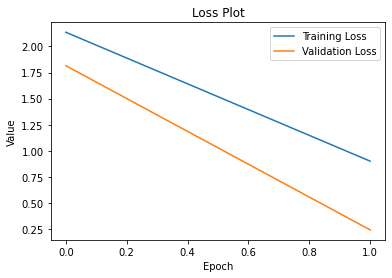

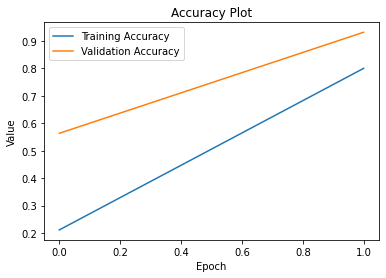

In [ ]:
graph_path = "/content/drive/My Drive/thesisHilman/grafik2/"

#plot train & validation loss
plt.figure(1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Plot')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="best")
plt.savefig(graph_path+'IndoBERT-LSTM Train & Validation Loss.png',dpi=300,bbox_inches='tight')

#plot train & validation accuracy
plt.figure(2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Plot')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="best")
plt.savefig(graph_path+'IndoBERT-LSTM Train & Validation Accuracy.png',dpi=300,bbox_inches='tight')

plt.show()

In [ ]:
checkpoint_path = "/content/drive/My Drive/thesisHilman/checkpoint2/"
model.load_weights(checkpoint_path+"128_checkpoint_indobert_lstm_1")

In [ ]:
Y_pred = model.predict(X_test)

34/34 [==============================] - 12s 266ms/step


<Figure size 432x288 with 0 Axes>

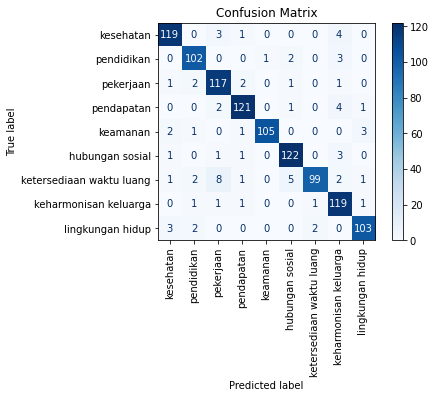

In [ ]:
labels = ['kesehatan', 'pendidikan', 'pekerjaan', 'pendapatan', 'keamanan', 
                 'hubungan sosial', 'ketersediaan waktu luang','keharmonisan keluarga','lingkungan hidup']
plt.figure(3)
cf_matrix = ConfusionMatrixDisplay.from_predictions(Y_test.argmax(axis=1), Y_pred.argmax(axis=1), cmap='Blues',display_labels=labels,xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.savefig(graph_path+'IndoBERT-LSTM Confusion Matrix.png',dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(Y_test.argmax(axis=1), Y_pred.argmax(axis=1), target_names=labels))

                          precision    recall  f1-score   support

               kesehatan       0.94      0.94      0.94       127
              pendidikan       0.93      0.94      0.94       108
               pekerjaan       0.89      0.94      0.91       124
              pendapatan       0.95      0.94      0.94       129
                keamanan       0.99      0.94      0.96       112
         hubungan sosial       0.93      0.95      0.94       128
ketersediaan waktu luang       0.97      0.83      0.90       119
   keharmonisan keluarga       0.88      0.96      0.92       124
        lingkungan hidup       0.94      0.94      0.94       110

                accuracy                           0.93      1081
               macro avg       0.93      0.93      0.93      1081
            weighted avg       0.93      0.93      0.93      1081



In [ ]:
print('Precision:', precision_score(Y_test.argmax(axis=1),Y_pred.argmax(axis=1), average='macro'))
print('Recall:', recall_score(Y_test.argmax(axis=1),Y_pred.argmax(axis=1), average='macro'))
print('F1-score:', f1_score(Y_test.argmax(axis=1),Y_pred.argmax(axis=1), average='macro'))

Precision: 0.9342625387829011
Recall: 0.9312871145009685
F1-score: 0.9317581791949032


AUC Score:  0.9961400992338247


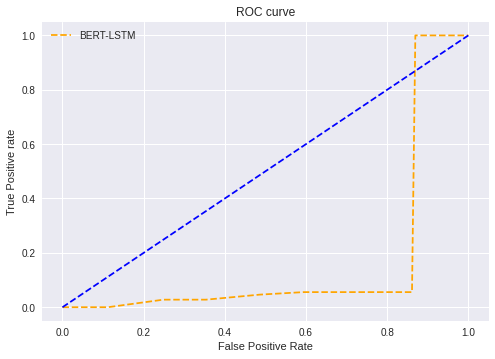

In [ ]:
#ROC Curve with OVR multi class one vs rest
from sklearn.metrics import roc_curve,roc_auc_score
# Model
fpr1, tpr1, thresh1 = roc_curve(Y_test.argmax(axis=1),Y_pred.argmax(axis=1), pos_label=1)
# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(Y_test))]
p_fpr, p_tpr, _ = roc_curve(Y_test.argmax(axis=1), random_probs, pos_label=1)

# auc scores
auc_score = roc_auc_score(Y_test,Y_pred,multi_class='ovo')
print('AUC Score: ',auc_score)

# Plot AUC-ROC
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='BERT-LSTM')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig(graph_path+'ROC.png',dpi=300)
plt.show();


In [ ]:
# Change value form dataset sentiment
dataset['sentiment'] = np.where((dataset.sentiment == '0'),'negatif',dataset.sentiment)
dataset['sentiment'] = np.where((dataset.sentiment == '1'),'netral',dataset.sentiment)
dataset['sentiment'] = np.where((dataset.sentiment == '2'),'positif',dataset.sentiment)


In [ ]:
data_test = dataset[['Tweet','sentiment']].values
label = labels
for i in range(1081):
  if Y_test.argmax(axis=1)[i] != Y_pred.argmax(axis=1)[i]:
    print('True Label:', label[Y_test.argmax(axis=1)[i]], '|', 'Predicted Label:', label[Y_pred.argmax(axis=1)[i]])
    print('Tweet:', data_test[i][0])
    print('Sentiment:', data_test[i][1], '\n')

True Label: hubungan sosial | Predicted Label: keharmonisan keluarga
Tweet: dari kemarin tulang belakang rasanya sakit pol semlm pas bapak di bawa ke rumah sakit tiba dada malah sesek pas sekali tidak ada orang di rumah gara ke rumah sakit semua sampai sekarang masih nyeri kalau buat apa
Sentiment: negatif 

True Label: keharmonisan keluarga | Predicted Label: pekerjaan
Tweet: desember sakit dan berat sekali ya
Sentiment: negatif 

True Label: hubungan sosial | Predicted Label: keharmonisan keluarga
Tweet: dia selalu bilang buat berobat dia bilang buat bayar rumah sakit ya husnudzon saja kalau dia memang sakit keras
Sentiment: negatif 

True Label: pendapatan | Predicted Label: keharmonisan keluarga
Tweet: ini kayanya masalah nya di saya deh ya menerima kenyataan saya sakit saja sudah berat bagaimana kalau ternyata saya bermasalah saya tidak yakin bakal sanggup menerima
Sentiment: negatif 

True Label: lingkungan hidup | Predicted Label: kesehatan
Tweet: kepala sakit dari semalam buat 